In [1]:
import pandas as pd
import numpy as np

# Create 1000 timestamps, hourly
timestamps = pd.date_range(start="2023-01-01", periods=1000, freq="H")

# Simulate a sinusoidal + trend signal
values = 0.5 * np.sin(np.linspace(0, 20*np.pi, 1000)) + 0.01*np.arange(1000)

df = pd.DataFrame({'date': timestamps, 'value': values})
df.to_csv("synthetic.csv", index=False)

In [29]:
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
import pandas as pd

# Load synthetic dataset
df = pd.read_csv("/ssd1/muntasir/Desktop/AutoTimes/dataset/custom/synthetic_multivariate.csv")
seq_len = 96
label_len = 48
token_len = seq_len - label_len  # 48

In [30]:
df

,date,feature1,feature2,feature3,target
0,2020-01-01,0.4967,1.3994,-0.6752,30.92
1,2020-01-02,-0.1383,0.9246,-0.1445,41.40
2,2020-01-03,0.6477,0.0596,-0.7924,45.86
3,2020-01-04,1.5230,-0.6469,-0.3080,68.88
4,2020-01-05,-0.2342,0.6982,-1.8936,55.57
...,...,...,...,...,...
995,2022-09-22,-0.2811,1.0702,0.0775,50.28
996,2022-09-23,1.7977,-0.0265,0.2578,29.22
997,2022-09-24,0.6408,-0.8819,-1.2418,46.80
998,2022-09-25,-0.5712,-0.1631,0.3342,66.43


In [19]:
token_len

48

In [20]:
df['date']

0      2023-01-01 00:00:00
1      2023-01-01 01:00:00
2      2023-01-01 02:00:00
3      2023-01-01 03:00:00
4      2023-01-01 04:00:00
              ...         
995    2023-02-11 11:00:00
996    2023-02-11 12:00:00
997    2023-02-11 13:00:00
998    2023-02-11 14:00:00
999    2023-02-11 15:00:00
Name: date, Length: 1000, dtype: object

In [21]:
token_len = 48
timestamps = df['date']

phrases = []
for i in range(0, len(timestamps) - token_len + 1):
    start = timestamps[i]
    end = timestamps[i + token_len - 1]
    phrase = f"This is Time Series from {start} to {end}"
    phrases.append(phrase)
    

print(len(phrases))

# Load small LLM tokenizer + model (simulate LLaMA)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")
model.eval()

953


/ssd1/muntasir/Desktop/AutoTimes/.autotimes/lib/python3.8/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [22]:
# Tokenize and embed
with torch.no_grad():
    embeddings = []
    for text in tqdm(phrases):
        tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        out = model(**tokens)
        emb = out.last_hidden_state.mean(dim=1)  # mean-pooling
        embeddings.append(emb.squeeze(0))
embeddings_tensor = torch.stack(embeddings)
torch.save(embeddings_tensor, "/ssd1/muntasir/Desktop/AutoTimes/dataset/custom/synthetic.pt")

print("Saved shape:", embeddings_tensor.shape)  # (N_chunks, embedding_dim)

100%|██████████| 953/953 [04:23<00:00,  3.62it/s]

Saved shape: torch.Size([953, 768])


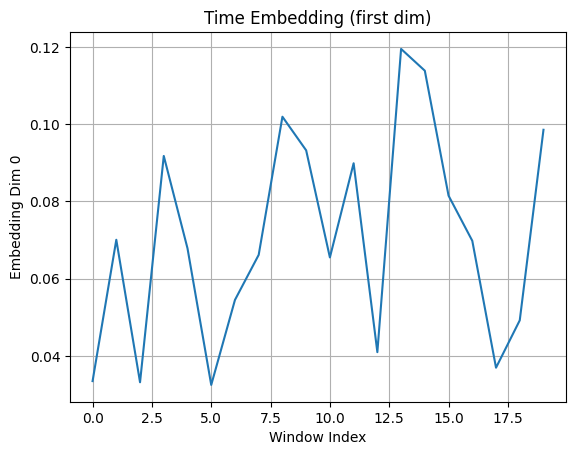

In [16]:
import torch
import matplotlib.pyplot as plt
emb = torch.load("/ssd1/muntasir/Desktop/AutoTimes/dataset/custom/synthetic.pt")
plt.plot(emb[:, 767].numpy())  # visualize the first dimension over time
plt.title("Time Embedding (first dim)")
plt.xlabel("Window Index")
plt.ylabel("Embedding Dim 0")
plt.grid(True)
plt.show()

In [13]:
emb.shape

torch.Size([20, 768])

In [31]:
import torch
import pandas as pd

df = pd.read_csv('/ssd1/muntasir/Desktop/AutoTimes/dataset/custom/synthetic_multivariate.csv')
emb = torch.load('/ssd1/muntasir/Desktop/AutoTimes/dataset/custom/synthetic_multivariate.pt')
print(df.shape, emb.shape)

(1000, 5) torch.Size([1000, 4096])


In [1]:
import pandas as pd

df = pd.read_csv('/ssd1/muntasir/Desktop/AutoTimes/dataset/panel/panel.csv')

In [2]:
df

,DATE,PERMNO,mean,std,capital_ratio,equity_invcap,debt_invcap,totdebt_invcap,at_turn,pay_turn,...,debt_capital,bm,CAPEI,evm,pe_exi,pe_inc,pe_op_basic,ps,ptb,actual
0,1990-03,10026.0,0.040000,0.016833,0.743945,0.245675,0.740484,0.744118,0.551724,0.346962,...,0.733542,0.237223,0.343678,0.104742,0.015073,0.016134,0.007815,0.149758,0.179795,0.0100
1,1990-06,10026.0,0.081000,0.026315,0.425606,0.560554,0.425606,0.482353,0.559387,0.384028,...,0.489028,0.447445,0.289091,0.106389,0.016763,0.017943,0.037037,0.130757,0.157540,0.0650
2,1990-09,10026.0,0.122500,0.010408,0.415225,0.574394,0.411765,0.476471,0.610473,0.375915,...,0.495298,0.494696,0.101030,0.091990,0.012918,0.013827,0.029010,0.055072,0.048316,0.1000
3,1990-12,10026.0,0.062500,0.002887,0.359862,0.629758,0.359862,0.423529,0.573436,0.113108,...,0.592476,0.795564,0.162989,0.030487,0.026191,0.028035,0.056475,0.100483,0.116545,0.0700
4,1991-03,10026.0,NaN,NaN,0.415225,0.574394,0.415225,0.470588,0.609195,0.093064,...,0.551724,0.584378,0.416283,0.036230,0.037627,0.040276,0.030859,0.190016,0.272914,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1132155,2020-12,93436.0,0.355900,0.103928,0.574468,0.922031,0.530324,0.607050,0.562698,0.236732,...,0.567616,0.161290,0.379009,0.218706,0.937244,0.937244,0.816659,0.709881,0.869912,0.2667
1132156,2021-03,93436.0,0.248168,0.058638,0.285106,0.961303,0.269394,0.280679,0.567966,0.212871,...,0.243772,0.112903,0.347179,0.272161,0.928803,0.912446,0.992077,0.595355,0.535953,0.3100
1132157,2021-06,93436.0,0.320422,0.107944,0.364539,0.950192,0.341326,0.383812,0.600632,0.220246,...,0.343416,0.137097,0.351347,0.246725,0.681774,0.681774,0.654319,0.539223,0.539192,0.4833
1132158,2021-09,93436.0,0.535452,0.093738,0.285106,0.960920,0.269394,0.284595,0.655427,0.229501,...,0.256228,0.145161,0.279661,0.248609,0.580909,0.580909,0.606642,0.538877,0.599352,0.6200


In [3]:
df = df[df['actual'].notna()]

In [4]:
df

,DATE,PERMNO,mean,std,capital_ratio,equity_invcap,debt_invcap,totdebt_invcap,at_turn,pay_turn,...,debt_capital,bm,CAPEI,evm,pe_exi,pe_inc,pe_op_basic,ps,ptb,actual
0,1990-03,10026.0,0.040000,0.016833,0.743945,0.245675,0.740484,0.744118,0.551724,0.346962,...,0.733542,0.237223,0.343678,0.104742,0.015073,0.016134,0.007815,0.149758,0.179795,0.0100
1,1990-06,10026.0,0.081000,0.026315,0.425606,0.560554,0.425606,0.482353,0.559387,0.384028,...,0.489028,0.447445,0.289091,0.106389,0.016763,0.017943,0.037037,0.130757,0.157540,0.0650
2,1990-09,10026.0,0.122500,0.010408,0.415225,0.574394,0.411765,0.476471,0.610473,0.375915,...,0.495298,0.494696,0.101030,0.091990,0.012918,0.013827,0.029010,0.055072,0.048316,0.1000
3,1990-12,10026.0,0.062500,0.002887,0.359862,0.629758,0.359862,0.423529,0.573436,0.113108,...,0.592476,0.795564,0.162989,0.030487,0.026191,0.028035,0.056475,0.100483,0.116545,0.0700
6,1991-09,10026.0,0.144000,0.006519,0.304498,0.681661,0.304498,0.367647,0.485313,0.017022,...,0.454545,0.321119,0.715248,0.052572,0.036451,0.039017,0.088695,0.328824,0.258858,0.1250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1132155,2020-12,93436.0,0.355900,0.103928,0.574468,0.922031,0.530324,0.607050,0.562698,0.236732,...,0.567616,0.161290,0.379009,0.218706,0.937244,0.937244,0.816659,0.709881,0.869912,0.2667
1132156,2021-03,93436.0,0.248168,0.058638,0.285106,0.961303,0.269394,0.280679,0.567966,0.212871,...,0.243772,0.112903,0.347179,0.272161,0.928803,0.912446,0.992077,0.595355,0.535953,0.3100
1132157,2021-06,93436.0,0.320422,0.107944,0.364539,0.950192,0.341326,0.383812,0.600632,0.220246,...,0.343416,0.137097,0.351347,0.246725,0.681774,0.681774,0.654319,0.539223,0.539192,0.4833
1132158,2021-09,93436.0,0.535452,0.093738,0.285106,0.960920,0.269394,0.284595,0.655427,0.229501,...,0.256228,0.145161,0.279661,0.248609,0.580909,0.580909,0.606642,0.538877,0.599352,0.6200


In [5]:
df.to_csv('/ssd1/muntasir/Desktop/AutoTimes/dataset/panel/panel_cleaned.csv', index=False)